In [0]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [0]:
def show_image_with_pyplot(img ,grayscale=True, ax=None, caption=None):
    if(len(img.shape) == 3): img_plt = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    else                   : img_plt = img

    if ax is None:
        fig = plt.figure(figsize=(14, 10))
        ax = plt.axes()
    
    if(caption is not None):
      ax.set_title(caption)
      
    ax.set_xticks([])
    ax.set_yticks([])
    
    if grayscale:   ax.imshow(img_plt, cmap='gray', vmin=0, vmax=255)
    else:           ax.imshow(img_plt, vmin=0, vmax=255)

In [0]:
def basic_preprocessing(img):
    # create a CLAHE object for Histogram equalisation and improvng the contrast.
    img_plt = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    x, y = max(img.shape[0]//200, 5), max(img.shape[1]//200, 5)
    clahe = cv2.createCLAHE(clipLimit=0.8, tileGridSize=(x,y))
    enhanced = clahe.apply(img_plt)

    # Edge preserving smoother: https://dsp.stackexchange.com/questions/60916/what-is-the-bilateral-filter-category-lpf-hpf-bpf-or-bsf
    x, y = max(img.shape[0]//200, 3), max(img.shape[1]//200, 3)
    blurred = cv2.GaussianBlur(enhanced, (x+(x+1)%2, y+(y+1)%2), 0)
    blurred = cv2.bilateralFilter(blurred,7,75,75)

    return blurred

# requires a grayscale image as input
def to_binary(img):
    # opening for clearing some noise
    se = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
    opened = cv2.morphologyEx(img, cv2.MORPH_OPEN, se)
    eroded = cv2

    thresholded_img = cv2.adaptiveThreshold(opened, 255, cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,5,2)
    inverted = cv2.bitwise_not(thresholded_img)
    return inverted

# def resize(image,window_height = 500):
#     aspect_ratio = float(image.shape[1])/float(image.shape[0])
#     window_width = window_height/aspect_ratio
#     image = cv2.resize(image, (int(window_height),int(window_width)), interpolation=cv2.INTER_AREA)
#     return image

(332, 484, 3)


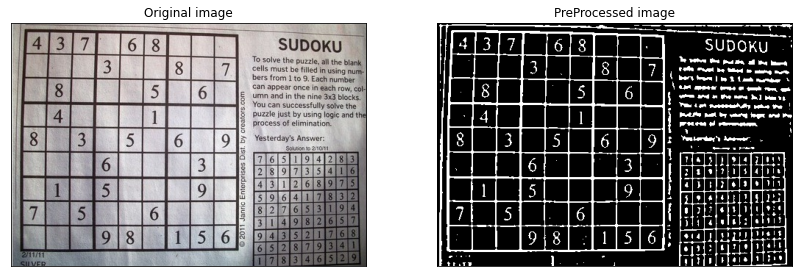

In [0]:
orig_img = cv2.imread("image1.jpg")
assert(orig_img.shape[0] > 200) and (orig_img.shape[1] > 200)
print(orig_img.shape)
inp_img = basic_preprocessing(orig_img)
fig = plt.figure(figsize=(14, 14))

ax1 = plt.subplot(121)
ax1.set_title("Original image")
ax1.set_xticks([])
ax1.set_yticks([])

ax2 = plt.subplot(122)
ax2.set_title("PreProcessed image")
ax2.set_xticks([])
ax2.set_yticks([])

ret_img = to_binary(inp_img)
kernel = np.ones((2,2))
eroded = cv2.erode(ret_img, kernel, iterations=1)

show_image_with_pyplot(orig_img, grayscale=False, ax=ax1)
show_image_with_pyplot(eroded, grayscale=True, ax=ax2)

In [0]:
# from skimage import io, morphology, img_as_bool, segmentation
# from scipy import ndimage as ndi

# def fill_gaps(img, iterations=2):
#   # Reference: https://stackoverflow.com/questions/28078530/gap-filling-contours-lines
#   for i in range(iterations):
#     out = ndi.distance_transform_edt(~img)
#     out = out < 0.05 * out.max()
#     out = morphology.skeletonize(out)
#     out = morphology.binary_closing(out, morphology.selem.disk(4))
#     out = segmentation.clear_border(out)
#     out = np.array(out*255, dtype=np.uint8)
#     out = cv2.bitwise_or(np.uint8(out), img)
#     img = out
#   return out

# refined_img = fill_gaps(ret_img, iterations=4)

# fig = plt.figure(figsize=(14, 14))
# ax1 = plt.subplot(121)
# ax1.set_title("Preprocessed image")
# ax1.set_xticks([])
# ax1.set_yticks([])

# ax2 = plt.subplot(122)
# ax2.set_title("Modified image")
# ax2.set_xticks([])
# ax2.set_yticks([])

# show_image_with_pyplot(ret_img, grayscale=True, ax=ax1)
# show_image_with_pyplot(refined_img, grayscale=True, ax=ax2)

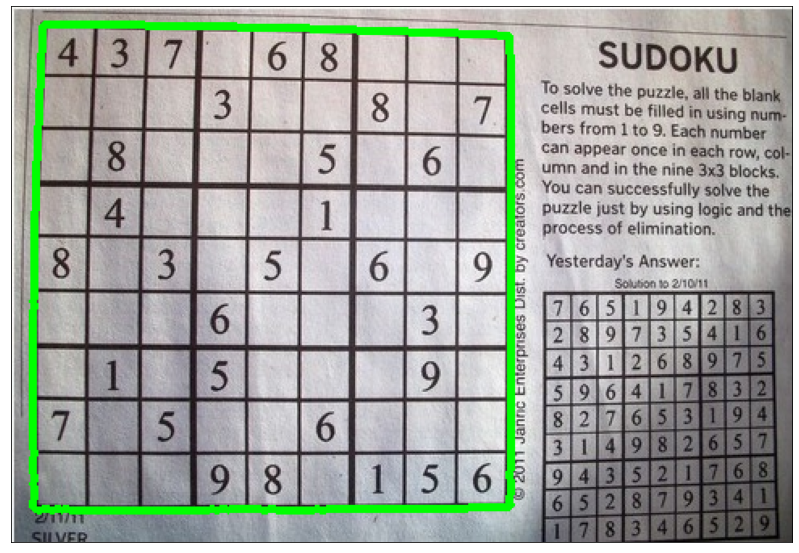

In [0]:
# find contours in the edged image, keep only the largest
contours, hierarchy = cv2.findContours(eroded.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
grid_cnt = np.array(sorted(contours, key=lambda x: cv2.contourArea(x), reverse=True))
draw_cnt = orig_img.copy()
main_contour = grid_cnt[0]
cv2.drawContours(draw_cnt, [main_contour], -1, (0, 255, 0), 3)

show_image_with_pyplot(draw_cnt, grayscale=False)

(array([20, 11], dtype=int32), array([308,  18], dtype=int32), array([308, 310], dtype=int32), array([ 13, 310], dtype=int32))
(array([20, 11], dtype=int32), array([308,  18], dtype=int32), array([308, 310], dtype=int32), array([ 13, 310], dtype=int32))
(4, 1, 2) [20 11] [ 13 310] [308 310] [308  18]


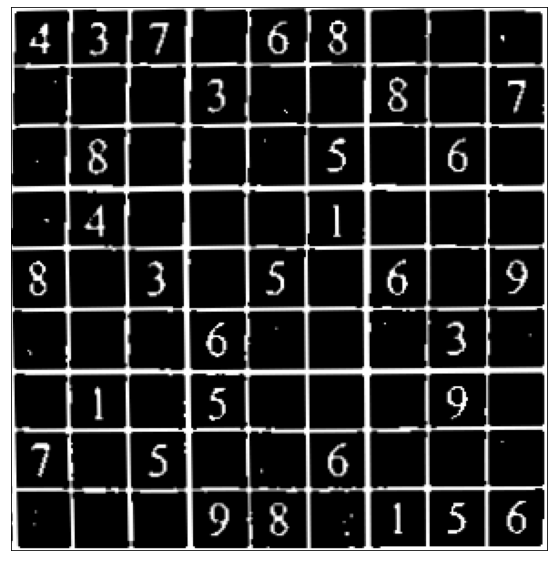

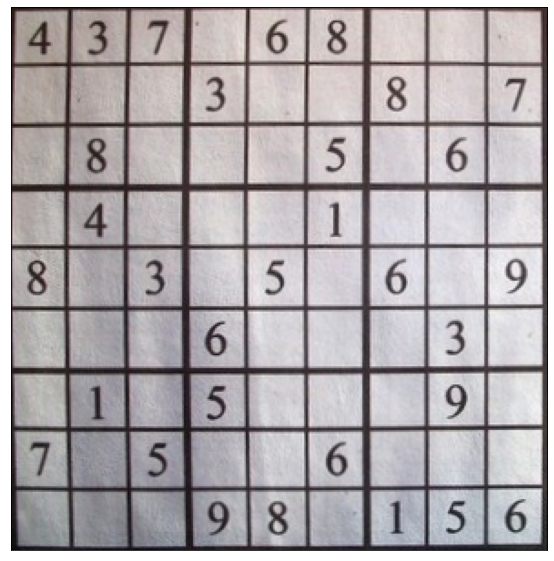

In [0]:
import operator
def perspective_transform(image, corners):
    # Reference: https://stackoverflow.com/questions/57636399/how-to-detect-sudoku-grid-board-in-opencv

    def order_corner_points(corners):
        # Bottom-right point has the largest (x + y) value
        # Top-left has point smallest (x + y) value
        # Bottom-left point has smallest (x - y) value
        # Top-right point has largest (x - y) value
        bottom_r, _ = max(enumerate([pt[0][0] + pt[0][1] for pt in corners]), key=operator.itemgetter(1))
        top_l = (bottom_r + 2)%4
        left_corners = [corners[i] for i in range(len(corners)) if((i!=bottom_r) and (i!=top_l))]
        bottom_l, _ = min(enumerate([pt[0][0] - pt[0][1] for pt in left_corners]), key=operator.itemgetter(1))
        top_r = (bottom_l + 1)%2
  
        return (corners[top_l][0], left_corners[top_r][0], corners[bottom_r][0], left_corners[bottom_l][0])

    # Order points in clockwise order
    ordered_corners = order_corner_points(corners)
    top_l, top_r, bottom_r, bottom_l = ordered_corners
    print(ordered_corners)

    # Determine width of new image which is the max distance between 
    # (bottom right and bottom left) or (top right and top left) x-coordinates
    width_A = np.sqrt(((bottom_r[0] - bottom_l[0]) ** 2) + ((bottom_r[1] - bottom_l[1]) ** 2))
    width_B = np.sqrt(((top_r[0] - top_l[0]) ** 2) + ((top_r[1] - top_l[1]) ** 2))
    width = max(int(width_A), int(width_B))

    # Determine height of new image which is the max distance between 
    # (top right and bottom right) or (top left and bottom left) y-coordinates
    height_A = np.sqrt(((top_r[0] - bottom_r[0]) ** 2) + ((top_r[1] - bottom_r[1]) ** 2))
    height_B = np.sqrt(((top_l[0] - bottom_l[0]) ** 2) + ((top_l[1] - bottom_l[1]) ** 2))
    height = max(int(height_A), int(height_B))

    # Construct new points to obtain top-down view of image in 
    # top_r, top_l, bottom_l, bottom_r order
    dimensions = np.array([[0, 0], [width - 1, 0], [width - 1, height - 1], 
                    [0, height - 1]], dtype = "float32")

    # Convert to Numpy format
    ordered_corners = np.array(ordered_corners, dtype="float32")

    # Find perspective transform matrix
    matrix = cv2.getPerspectiveTransform(ordered_corners, dimensions)

    # Return the transformed image
    return cv2.warpPerspective(image, matrix, (width, height))

peri = cv2.arcLength(main_contour, True)
approx = cv2.approxPolyDP(main_contour, 0.1 * peri, True)
# cv2.circle(orig_img, (approx[0][0][0], approx[0][0][1]), 3, (0,255,0), 2)
# cv2.circle(orig_img, (approx[1][0][0], approx[1][0][1]), 3, (0,255,0), 2)
# cv2.circle(orig_img, (approx[2][0][0], approx[2][0][1]), 3, (0,255,0), 2)
# cv2.circle(orig_img, (approx[3][0][0], approx[3][0][1]), 3, (0,255,0), 2)
transformed_processed = perspective_transform(eroded, approx[0:4])
transformed_orig = perspective_transform(orig_img, approx)
print(approx.shape, approx[0][0], approx[1][0], approx[2][0], approx[3][0])

show_image_with_pyplot(transformed_processed, grayscale=True)
show_image_with_pyplot(transformed_orig, grayscale=False)


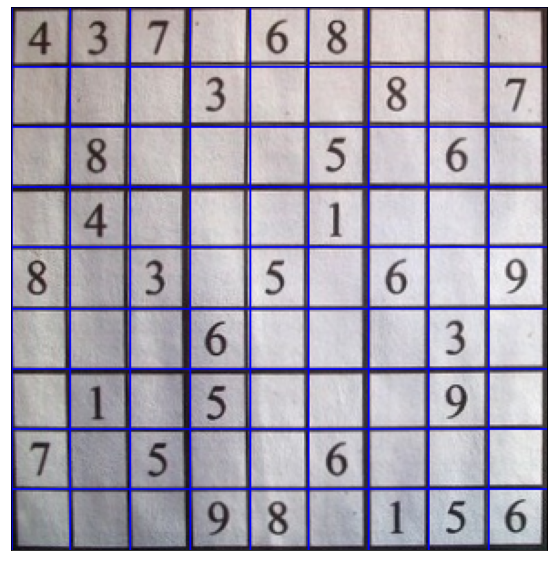

In [0]:
test = transformed_processed.copy()
test_orig = transformed_orig.copy()

lines_X = np.linspace(0, test.shape[1], num=10, dtype=int)
lines_Y = np.linspace(0, test.shape[0], num=10, dtype=int)

for line_X in lines_X:
    x1 = line_X
    y1 = 0
    x2 = x1
    y2 = test.shape[0]
    cv2.line(test_orig,(x1,y1),(x2,y2),(255,0,0),1)

for line_Y in lines_Y:
    y1 = line_Y
    x1 = 0
    y2 = y1
    x2 = test.shape[1]
    cv2.line(test_orig,(x1,y1),(x2,y2),(255,0,0),1)

show_image_with_pyplot(test_orig, grayscale=False)

In [0]:
print(lines_X)
print(lines_Y)

[  0  32  65  98 131 163 196 229 262 295]
[  0  33  66  99 132 166 199 232 265 299]


In [0]:
centers_X = [(lines_X[i] + lines_X[i-1])//2 for i in range(1, len(lines_X))]
print(centers_X)

[16, 48, 81, 114, 147, 179, 212, 245, 278]


In [0]:
centers_Y = [(lines_Y[i] + lines_Y[i-1])//2 for i in range(1, len(lines_Y))]
print(centers_Y)

[16, 49, 82, 115, 149, 182, 215, 248, 282]


In [0]:
centers = [(centers_X[i], centers_Y[j]) for i in range(len(centers_X)) for j in range(len(centers_Y))]
print(centers[:10])

[(16, 16), (16, 49), (16, 82), (16, 115), (16, 149), (16, 182), (16, 215), (16, 248), (16, 282), (48, 16)]


In [0]:
kernel_shape = (centers_X[1] - centers_X[0], centers_Y[1] - centers_Y[0])
print(kernel_shape)

(32, 33)


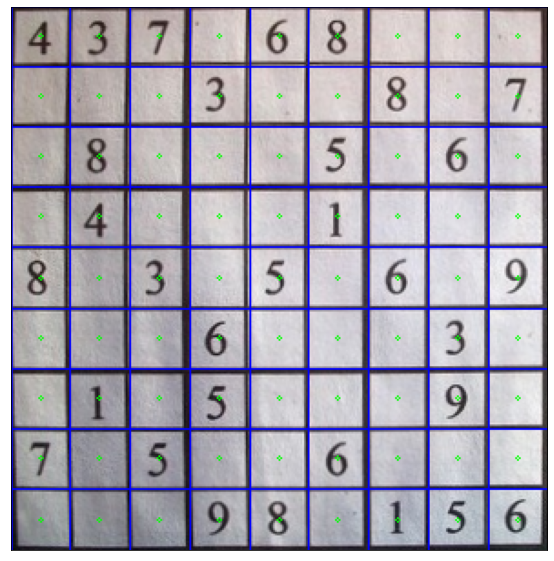

In [0]:
radius, color, thickness = kernel_shape[0]//20, (0,255,0), kernel_shape[0]//20
for center in centers:
  cv2.circle(test_orig, center, radius, color, thickness)
show_image_with_pyplot(test_orig, grayscale=True)

In [0]:
# create structuring element
def centering_se(shape: tuple, shape_ones: (int, int)):
  x = np.zeros(shape)
  assert (shape_ones[0] < shape[0]) and (shape_ones[1] < shape[1])
  width = shape_ones[0]
  height = shape_ones[1]
  
  rows, cols = shape
  for i in range(width):
    for j in range(height):
      x[i][j], x[rows-1-i][j], x[i][cols-1-j], x[rows-1-i][cols-1-j] = 1, 1, 1, 1

  return x

In [0]:
print(centering_se(kernel_shape, (2,15)))

[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


In [0]:
def recentre(img: np.ndarray, prev_center: tuple, h_se: np.ndarray, v_se: np.ndarray, h_mov_range: (int, int), v_mov_range: (int, int)):
  # reference: https://web.stanford.edu/class/ee368/Project_Spring_1415/Reports/Wang.pdf
  max_res, max_center = 0, prev_center

  for i in range(v_mov_range[0], v_mov_range[1]):
    curr_center = (prev_center[0] + 0, prev_center[1] + i)
    start_row = max(curr_center[1] - v_se.shape[0]//2, 0)
    start_col = max(curr_center[0] - v_se.shape[1]//2, 0)
    partial = img[start_row:start_row+v_se.shape[0], start_col:start_col+v_se.shape[1]]

    curr_dot = np.sum(partial*(v_se[0:partial.shape[0], 0:partial.shape[1]]))
    # curr_dot = np.sum(img[x1:x1+v_se.shape[0], y1:y1+v_se.shape[1]]*(v_se))
    # print(curr_center, curr_dot)
    if max_res < curr_dot:
      max_res = curr_dot
      max_center = curr_center

  # # print("max_center after v_se: ", max_center)
  prev_center = max_center
  max_res = 0
  for i in range(h_mov_range[0], h_mov_range[1]):
    curr_center = (prev_center[0] + i, prev_center[1] + 0)
    start_row = max(curr_center[1] - h_se.shape[0]//2, 0)
    start_col = max(curr_center[0] - h_se.shape[1]//2, 0)
    partial = img[start_row:start_row+h_se.shape[0], start_col:start_col+h_se.shape[1]]

    curr_dot = np.sum(partial*(h_se[0:partial.shape[0], 0:partial.shape[1]]))
    # print(curr_center, curr_dot)
    if max_res < curr_dot:
      max_res = curr_dot
      max_center = curr_center
      
  # print("max_center after h_se: ", max_center)
  return max_center

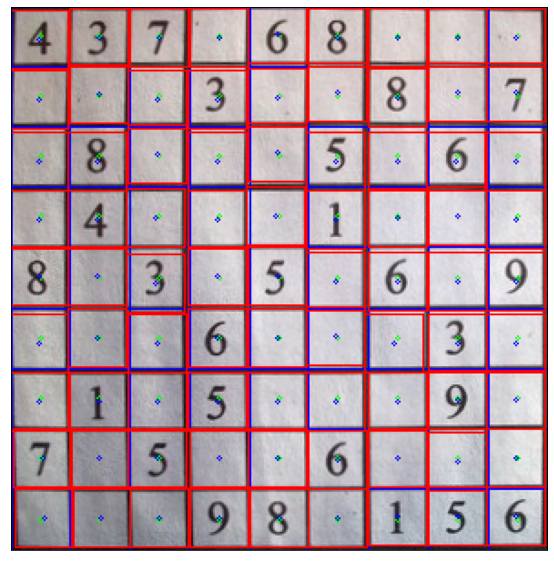

In [0]:
ones_length = (kernel_shape[0]+kernel_shape[1])//20
v_se = centering_se(kernel_shape, (2,ones_length))
h_se = centering_se(kernel_shape, (ones_length,2))

tt = test_orig.copy()
new_centers = []
for i in range(len(centers)):
  v_mov_range, h_mov_range = (-kernel_shape[0]//8, kernel_shape[0]//8), (-kernel_shape[1]//8, kernel_shape[1]//8)
  if (i<9)            : h_mov_range = (-kernel_shape[1]//64, kernel_shape[1]//8)
  elif (i>71)         : h_mov_range = (-kernel_shape[1]//8, kernel_shape[1]//64)
  if (i%9 == 0)       : v_mov_range = (-kernel_shape[0]//64, kernel_shape[0]//8)
  elif ((i+1)%9 == 0) : v_mov_range = (-kernel_shape[0]//8, kernel_shape[0]//64)

  new_centers.append(recentre(transformed_processed, centers[i], h_se, v_se, h_mov_range, v_mov_range))

for center in new_centers:
  cv2.circle(tt, center, radius, (255,0,0), thickness)
  cv2.rectangle(tt, (center[0]-kernel_shape[1]//2, center[1]-kernel_shape[0]//2), (center[0]+kernel_shape[1]//2, center[1]+kernel_shape[0]//2), (0,0,255), thickness)  

show_image_with_pyplot(tt, False)

In [0]:
def preprocess_digit(digit_img):
  # remove possible edges from border
  digit_img[0:3,:] = 0
  digit_img[:,0:3] = 0
  digit_img[-3:,:] = 0
  digit_img[:,-3:] = 0

  # # dilate the digit
  # se = cv2.getStructuringElement(cv2.MORPH_CROSS,(2,2))
  # closed = cv2.morphologyEx(digit_img, cv2.MORPH_CLOSE, se)

  return digit_img

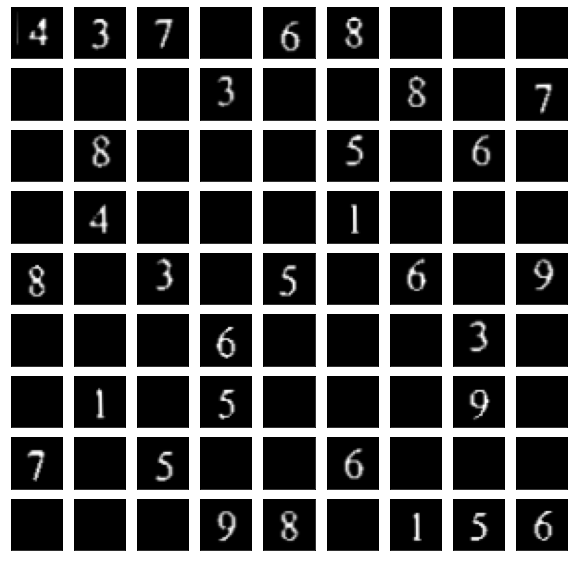

In [0]:
# extracting digits
fig, axes = plt.subplots(9, 9)
fig.set_size_inches(10,10)
i=0
digits = []
for center in new_centers:
  top_l = [center[0]-kernel_shape[1]//2, center[1]-kernel_shape[0]//2]
  top_r = [center[0]+kernel_shape[1]//2, center[1]-kernel_shape[0]//2]
  bottom_l = [center[0]-kernel_shape[1]//2, center[1]+kernel_shape[0]//2]
  bottom_r = [center[0]+kernel_shape[1]//2, center[1]+kernel_shape[0]//2]

  M = cv2.getPerspectiveTransform(np.float32([top_l, top_r, bottom_l, bottom_r]), np.float32([[0,0], [28,0], [0,28], [28,28]]))
  dst = cv2.warpPerspective(transformed_processed,M,(28,28))
  dst_mod = preprocess_digit(dst)
  if(np.sum(dst_mod) > 255*30):
    show_image_with_pyplot(dst_mod, grayscale=True, ax=axes[i%9,i//9])
    digits.append(dst_mod)
  else:
    show_image_with_pyplot(np.zeros(dst_mod.shape), grayscale=True, ax=axes[i%9,i//9])
    digits.append(np.zeros(dst_mod.shape))
  # else:
    # show_image_with_pyplot(dst+255, grayscale=True, ax=axes[i%9,i//9])
  i+=1
  # top_l, top_r, bottom_l, bottom_r = (center[0]-kernel_shape[1]//2, center[1]-kernel_shape[0]//2), (center[0]+kernel_shape[1]//2, center[1]+kernel_shape[0]//2)
  # cv2.circle(tt, center, 5, (255,0,0), 10)
  # cv2.rectangle(tt, (center[0]-kernel_shape[1]//2, center[1]-kernel_shape[0]//2), (center[0]+kernel_shape[1]//2, center[1]+kernel_shape[0]//2), (0,0,255), 5) 

In [0]:
# Assumes digits in column major order
def get_extracted_digits_img(digits: list, rows: int, cols: int) -> np.ndarray:
  combined = np.array([])
  for i in range(cols):
    bordered_digit = cv2.copyMakeBorder(digits[i*rows],2,2,2,2,cv2.BORDER_CONSTANT,value=255)
    col_combined = bordered_digit
    for j in range(1, rows):
      bordered_digit = cv2.copyMakeBorder(digits[i*rows + j],2,2,2,2,cv2.BORDER_CONSTANT,value=255)
      col_combined = np.vstack((col_combined, bordered_digit))

    if i == 0:
      combined = col_combined
    else:
      combined = np.hstack((combined, col_combined))
  
  return combined

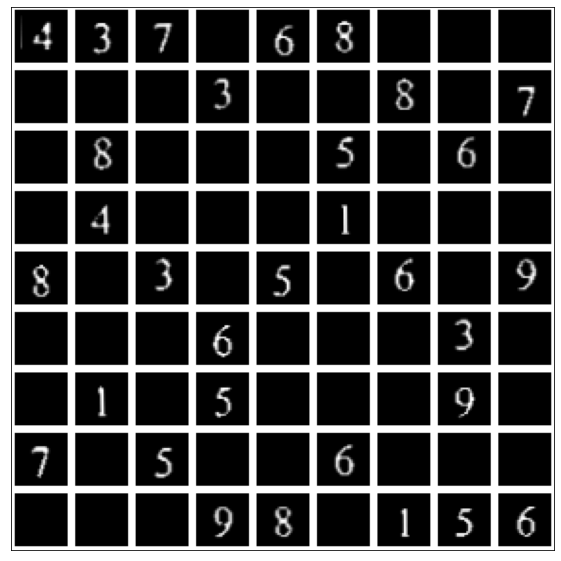

In [0]:
combined = get_extracted_digits_img(digits, 9, 9)
show_image_with_pyplot(combined)

In [0]:
s = "437.68......3..8.7.8...5.6..4...1...8.3.5.6.9...6...3..1.5...9.7.5..6......98.156"
for i in range(9):
  for j in range(9):
    # label by row_major order
    curr_symbol = s[j*9+i]
    if(curr_symbol != '.'):
      y_train = np.append(int(curr_symbol), y_train)
      curr_img = digits[i*9+j].reshape((1, -1))
      X_train = np.append(curr_img, X_train, axis=0)

In [0]:
def plot_sudoku(n, ax):
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Simple plotting statement that ingests a 9x9 array (n), and plots a sudoku-style grid around it.
    for y in range(10):
        ax.plot([-0.05,9.05],[y,y],color='black',linewidth=1)
        
    for y in range(0,10,3):
        ax.plot([-0.05,9.05],[y,y],color='black',linewidth=3)
            
    for x in range(10):
        ax.plot([x,x],[-0.05,9.05],color='black',linewidth=1)
    
    for x in range(0,10,3):
        ax.plot([x,x],[-0.05,9.05],color='black',linewidth=3)

    # plt.axis('image')
    # plt.axis('off') # drop the axes, they're not important here

    for x in range(9):
        for y in range(9):
            foo=n[8-y][x] # need to reverse the y-direction for plotting
            if foo > 0: # ignore the zeros
                T=str(foo)
                ax.text(x+0.3,y+0.2,T,fontsize=20)

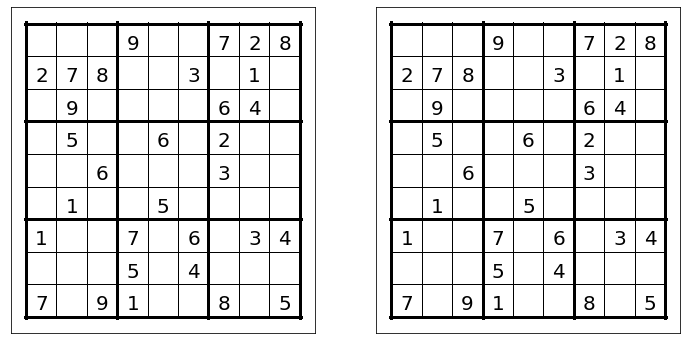

In [0]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(12,6)
sudoku_hard=np.array([[0,0,0,9,0,0,7,2,8],
                      [2,7,8,0,0,3,0,1,0],
                      [0,9,0,0,0,0,6,4,0],
                      [0,5,0,0,6,0,2,0,0],
                      [0,0,6,0,0,0,3,0,0],
                      [0,1,0,0,5,0,0,0,0],
                      [1,0,0,7,0,6,0,3,4],
                      [0,0,0,5,0,4,0,0,0],
                      [7,0,9,1,0,0,8,0,5]])
plot_sudoku(sudoku_hard, ax[0])
plot_sudoku(sudoku_hard, ax[1])

In [0]:
X_train = np.loadtxt('X_train.csv', dtype=np.uint8, delimiter=' ')
y_train = np.loadtxt('y_train.csv', dtype=np.uint8, delimiter=' ')
# X_train = X_train[19*6:]
# y_train = y_train[19*6:]

In [0]:
print(X_train.shape)
print(y_train.shape)

(313, 784)
(313,)


In [0]:
np.savetxt('X_train.csv', X_train)
print(X_train.shape)

(313, 784)


In [0]:
np.savetxt('y_train.csv', y_train.reshape((-1,1)))

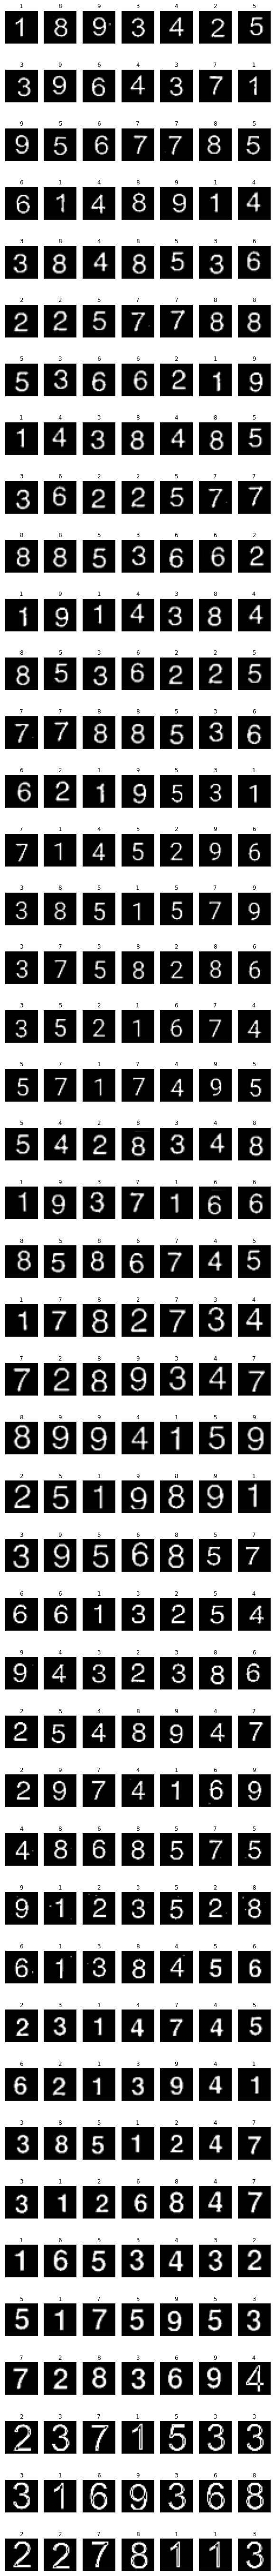

In [0]:
rows, cols = 44,7
fig, ax = plt.subplots(rows,cols)
fig.set_size_inches(w=10, h=100)
for i in range(rows):
  for j in range(cols):
    show_image_with_pyplot(X_train[i*cols + j].reshape((28, 28)), grayscale=True, ax=ax[i,j], caption=y_train[i*cols + j])